In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/splcher/animefacedataset'
od.download(dataset_url)

Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


100%|██████████| 395M/395M [00:03<00:00, 126MB/s]


In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as T

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_tfms = T.Compose([T.Resize(image_size),
                        T.CenterCrop(image_size),
                        T.ToTensor(),
                        T.Normalize(*stats)])

train_ds = ImageFolder('./animefacedataset/', train_tfms)
train_dl = DataLoader(train_ds, batch_size, True)

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

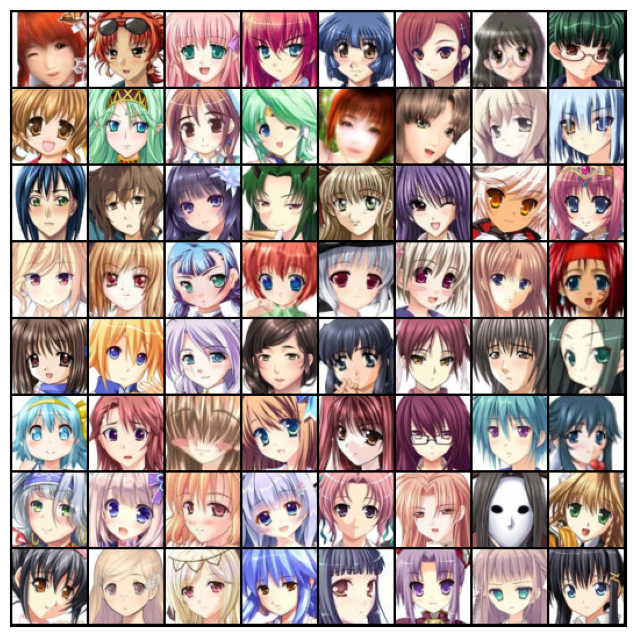

In [ ]:
show_batch(train_dl)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]

  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for x in self.dl:
      yield to_device(x, self.device)

  def __len__(self):
    return len(self.dl)

In [ ]:
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
import torch.nn as nn

discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=True),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=True),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, 4, 2, 1, bias=True),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, 4, 2, 1, bias=True),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, 4, 1, 0, bias=False),

    nn.Flatten(),
    nn.Sigmoid()

)

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

torch.Size([128, 3, 64, 64])


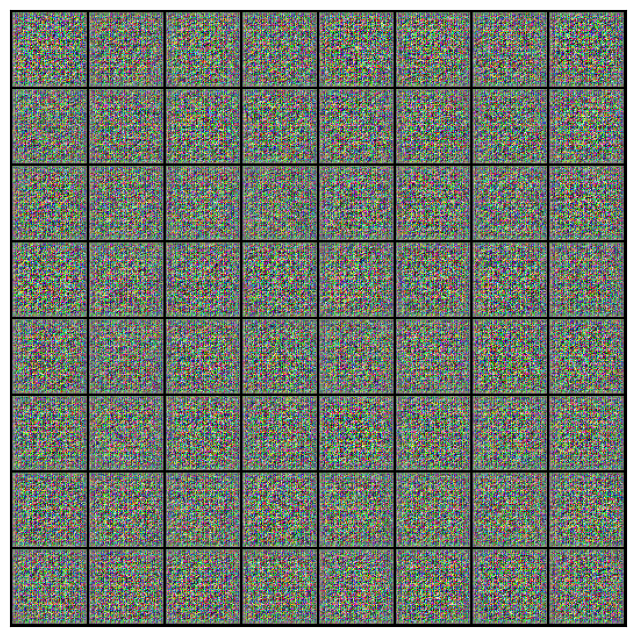

In [ ]:
x = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(x)
print(fake_images.shape)
show_batch([(fake_images, 0)])

In [ ]:
generator = to_device(generator, device)

In [ ]:
import torch.nn.functional as F

In [ ]:
def train_discriminator(real_images, opt_d):
  opt_d.zero_grad()

  #pass real images through discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  #create fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  #pass the fake images through discriminator
  fake_preds = discriminator(fake_images)
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  #update discriminator
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()

  return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
  opt_g.zero_grad()

  # Generate Fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  # try to fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(fake_images.size(0), 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  #update generator weights
  loss.backward()
  opt_g.step()

  return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
import os
os.makedirs('generated', exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join('generated', fake_fname), nrow=8)
  print('saving', fake_fname)

  if show:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(make_grid(denorm(fake_images.cpu().detach()), nrow=8).permute(1,2,0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

saving generated-images-0000.png


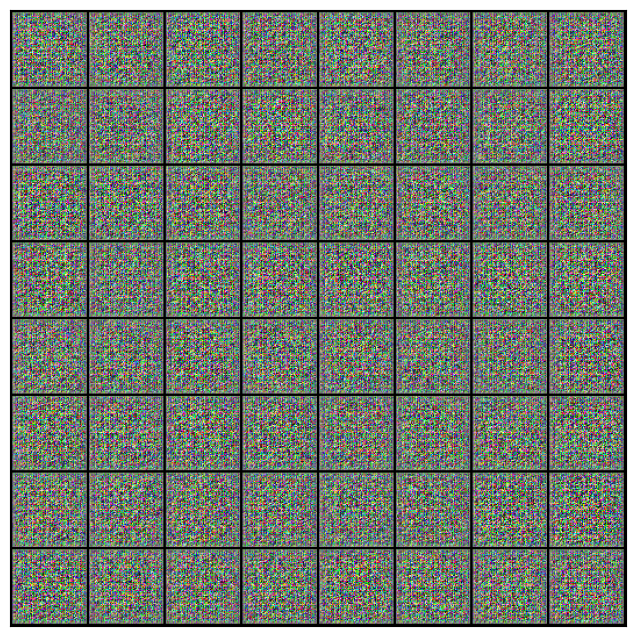

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
  torch.cuda.empty_cache()

  #losses and scores
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  #create optimizer
  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for real_images, _ in tqdm(train_dl):
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      loss_g = train_generator(opt_g)

    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)


    print(f"Epoch: {epoch+1} | loss_g: {loss_g} | loss_d: {loss_d} | real_score: {real_score} | fake_score: {fake_score}")

    save_samples(epoch+start_idx, fixed_latent, False)

  return losses_g, losses_d, real_score, fake_score

In [ ]:
lr = 0.0002
epochs = 10

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 1 | loss_g: 2.733870506286621 | loss_d: 0.295526921749115 | real_score: 0.8912709951400757 | fake_score: 0.14003309607505798
saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 2 | loss_g: 6.340121746063232 | loss_d: 0.5300316214561462 | real_score: 0.6615931987762451 | fake_score: 0.003384675830602646
saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 3 | loss_g: 4.401643753051758 | loss_d: 0.2989599108695984 | real_score: 0.875678539276123 | fake_score: 0.1259385049343109
saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 4 | loss_g: 13.330791473388672 | loss_d: 0.5958073139190674 | real_score: 0.9893993139266968 | fake_score: 0.39547955989837646
saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 5 | loss_g: 4.824000358581543 | loss_d: 0.22731004655361176 | real_score: 0.8941782116889954 | fake_score: 0.08701379597187042
saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 6 | loss_g: 7.720712661743164 | loss_d: 0.37918734550476074 | real_score: 0.9180946946144104 | fake_score: 0.22088679671287537
saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 7 | loss_g: 5.846461296081543 | loss_d: 0.2547193169593811 | real_score: 0.9382911920547485 | fake_score: 0.15422190725803375
saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 8 | loss_g: 8.69489574432373 | loss_d: 0.4031481146812439 | real_score: 0.7441281676292419 | fake_score: 0.0005791927105747163
saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 9 | loss_g: 4.149483680725098 | loss_d: 0.16911520063877106 | real_score: 0.9076840281486511 | fake_score: 0.03992078825831413
saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 10 | loss_g: 4.775032997131348 | loss_d: 0.08505211025476456 | real_score: 0.9721081256866455 | fake_score: 0.052000682801008224
saving generated-images-0010.png


In [ ]:
import cv2
import os

image_folder = 'generated'


video_name = 'epoch_output_video.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images.sort()

first_image_path = os.path.join(image_folder, images[0])
frame = cv2.imread(first_image_path)
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), 1, (width, height))

for image in images:
    image_path = os.path.join(image_folder, image)
    frame = cv2.imread(image_path)
    video.write(frame)

video.release()

print(f'Video saved as {video_name}')



Video saved as epoch_output_video.mp4
